# Ensemble Machine Learning with Wine


Name: Gabriel Richards

Date: 10 Apr 2025

Introduction: In Vino, Veritas! This notebook explores ensemble machine learning methods to predict wine quality. Wine quality represents a great topic for ensemble methods, as the subjective human perception of quality emerges from complex interactions between multiple objectively measurable properties. Let's go see if we can find the truth in the wine.

## 0. Imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


# Set the state_setter variable for all instances of random_state to compare outcomes between seeds
# This seed influences how test_train_split cuts the data and the ensemble models make their predictions
state_setter=404

We're going to be using pandas and numpy to perform our basic statistics and data frame handling, matplotlib and seaborn for data plotting, and sklearn for training our models.

We'll leverage several models from sklearn to determine which approach best captures the subtle patterns that distinguish exceptional wines from mediocre ones. 



## 1. Load & Inspect Data

In [282]:
# Load the dataset
wine_data = pd.read_csv('winequality-red.csv', sep=';')

# Get information about the dataset structure
print("Dataset Information:")
wine_data.info()

# Check the shape of the dataset
print("\nDataset shape (rows, columns):")
print(wine_data.shape)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Dataset shape (rows, columns):
(1599, 12)


Our dataset has 1599 entries/rows with 12 total columns (also called features), all of which are numeric and none of which are categorical. The only non-float column is quality. This is unfortunate for reasons we will find out as we dive deeper into the study.

### Dataset Dictionary

Here is a brief description of what each column or feature represents.

#### Wine Quality Features:

- **Fixed Acidity**: Primary acids in wine (mainly tartaric acid) that don't evaporate readily; contributes to structure and aging potential.
- **Volatile Acidity**: Primarily acetic acid that can evaporate; at high levels creates vinegar-like off-flavors.
- **Citric Acid**: Adds freshness and flavor to wines; found in small quantities and contributes to the wine's acidity profile.
- **Residual Sugar**: Amount of sugar remaining after fermentation stops; influences sweetness.
- **Chlorides**: Amount of salt in the wine; high levels can give a salty taste.
- **Free Sulfur Dioxide**: Unbound form of SO₂ that prevents microbial growth and oxidation.
- **Total Sulfur Dioxide**: Sum of free and bound SO₂; high levels can cause off-odors and allergic reactions.
- **Density**: Ratio of mass to volume, influenced by alcohol and sugar content; typically slightly less than water.
- **pH**: Measure of acidity on a 0-14 scale; wines typically range from 3-4 with lower values indicating acidity.
- **Sulphates**: Additive that acts as an antimicrobial and antioxidant.
- **Alcohol**: Percentage of alcohol by volume
- **Quality**: Sensory score as an integer between 0 and 10, measuring human-evaluated quality of the wine.

Let's look a little closer at what the data actually looks like.

In [283]:
# View the first few rows
print("\nFirst 5 rows of the dataset:")
print(wine_data.head())




First 5 rows of the dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          7.400             0.700        0.000           1.900      0.076   
1          7.800             0.880        0.000           2.600      0.098   
2          7.800             0.760        0.040           2.300      0.092   
3         11.200             0.280        0.560           1.900      0.075   
4          7.400             0.700        0.000           1.900      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0               11.000                34.000    0.998 3.510      0.560   
1               25.000                67.000    0.997 3.200      0.680   
2               15.000                54.000    0.997 3.260      0.650   
3               17.000                60.000    0.998 3.160      0.580   
4               11.000                34.000    0.998 3.510      0.560   

   alcohol  quality  
0    9.400        5  
1    9.800  

The data looks well formatted and easy to read.

In [284]:
# Get statistical summary of numerical features
print("\nStatistical summary of features:")
print(wine_data.describe())





Statistical summary of features:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count       1599.000          1599.000     1599.000        1599.000   
mean           8.320             0.528        0.271           2.539   
std            1.741             0.179        0.195           1.410   
min            4.600             0.120        0.000           0.900   
25%            7.100             0.390        0.090           1.900   
50%            7.900             0.520        0.260           2.200   
75%            9.200             0.640        0.420           2.600   
max           15.900             1.580        1.000          15.500   

       chlorides  free sulfur dioxide  total sulfur dioxide  density       pH  \
count   1599.000             1599.000              1599.000 1599.000 1599.000   
mean       0.087               15.875                46.468    0.997    3.311   
std        0.047               10.460                32.895    0.002    0.154   
mi

All columns have the same count, which is reassuring as we look ahead to data cleaning. Different features varied widely, with Density remaining very close to 1 but 

## 2. Prepare the Data
Before we begin our analysis, let's get the data set up for use by removing any bad values and taking an initial look at the target variable we'll be evaluating - quality.

### 2.1 Data Cleaning & Prep

First let's clean the dataset to confirm there are no issues with it.

In [285]:
# Check for missing values
print("\nMissing values in each column:")
print(wine_data.isnull().sum())


Missing values in each column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Fortunately, this data set comes clean as a whistle and has no missing, null, or visibly corrupted values.

### 2.2 Feature Engineering

#### 2.2.1 Data Probing

Let's look a little closer at the data to see how it's distributed and determine good options for our ensemble models.

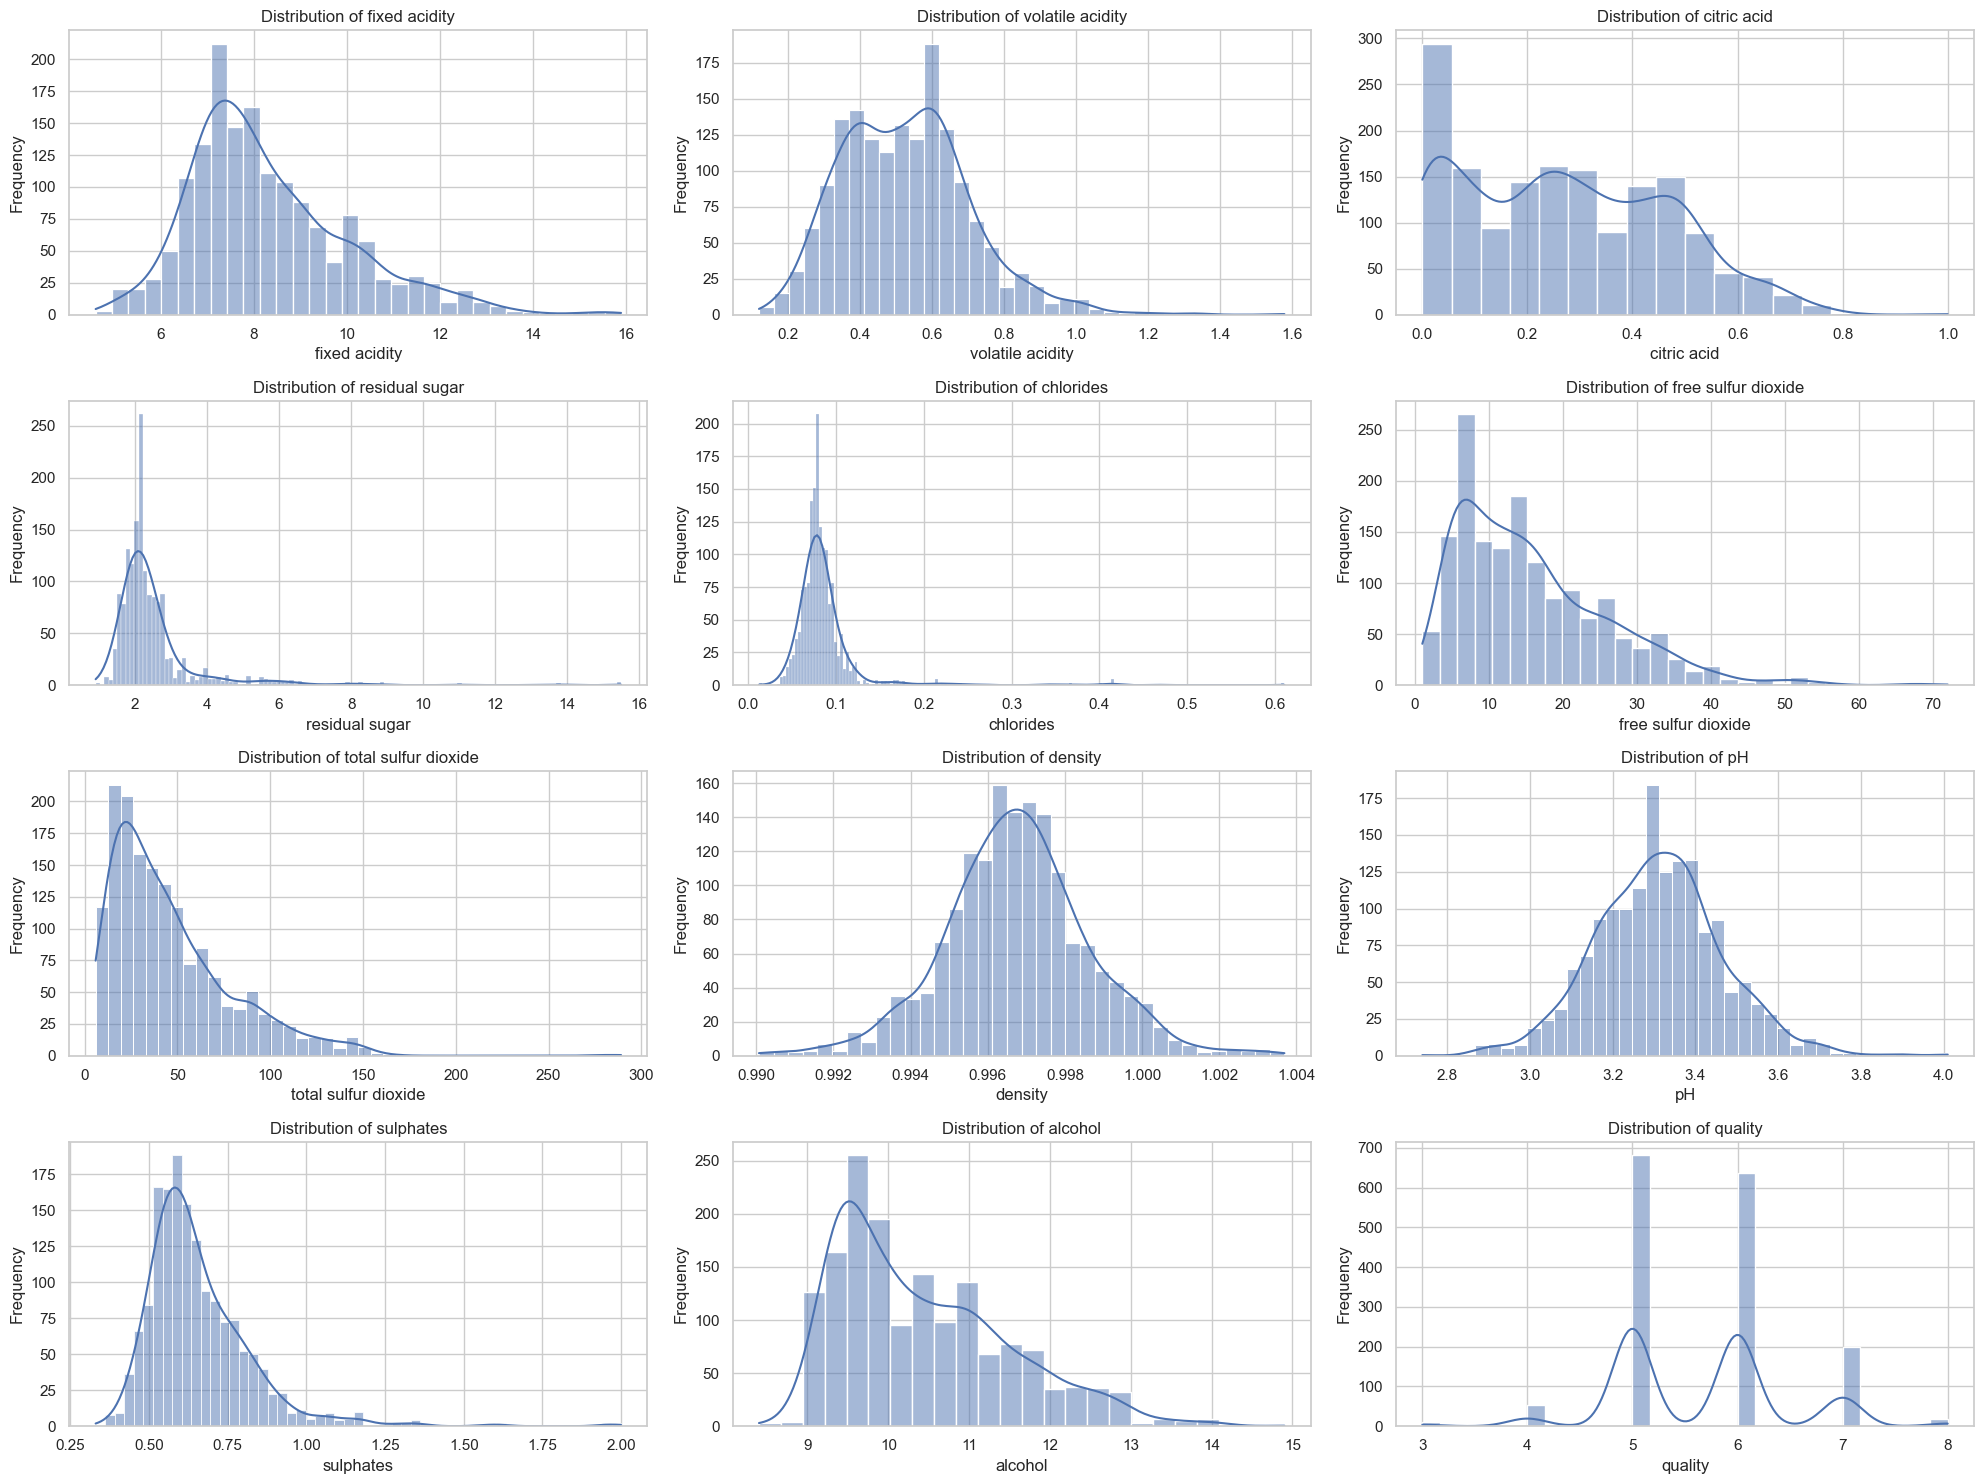

In [286]:
# Set the style for our plots
sns.set(style="whitegrid")



# Create histograms for each feature
feature_names = wine_data.columns
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names):
    plt.subplot(4, 3, i+1)
    sns.histplot(wine_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This shows us all of the features in the data set generally follow a bell curve, although some are right skewed or left skewed.

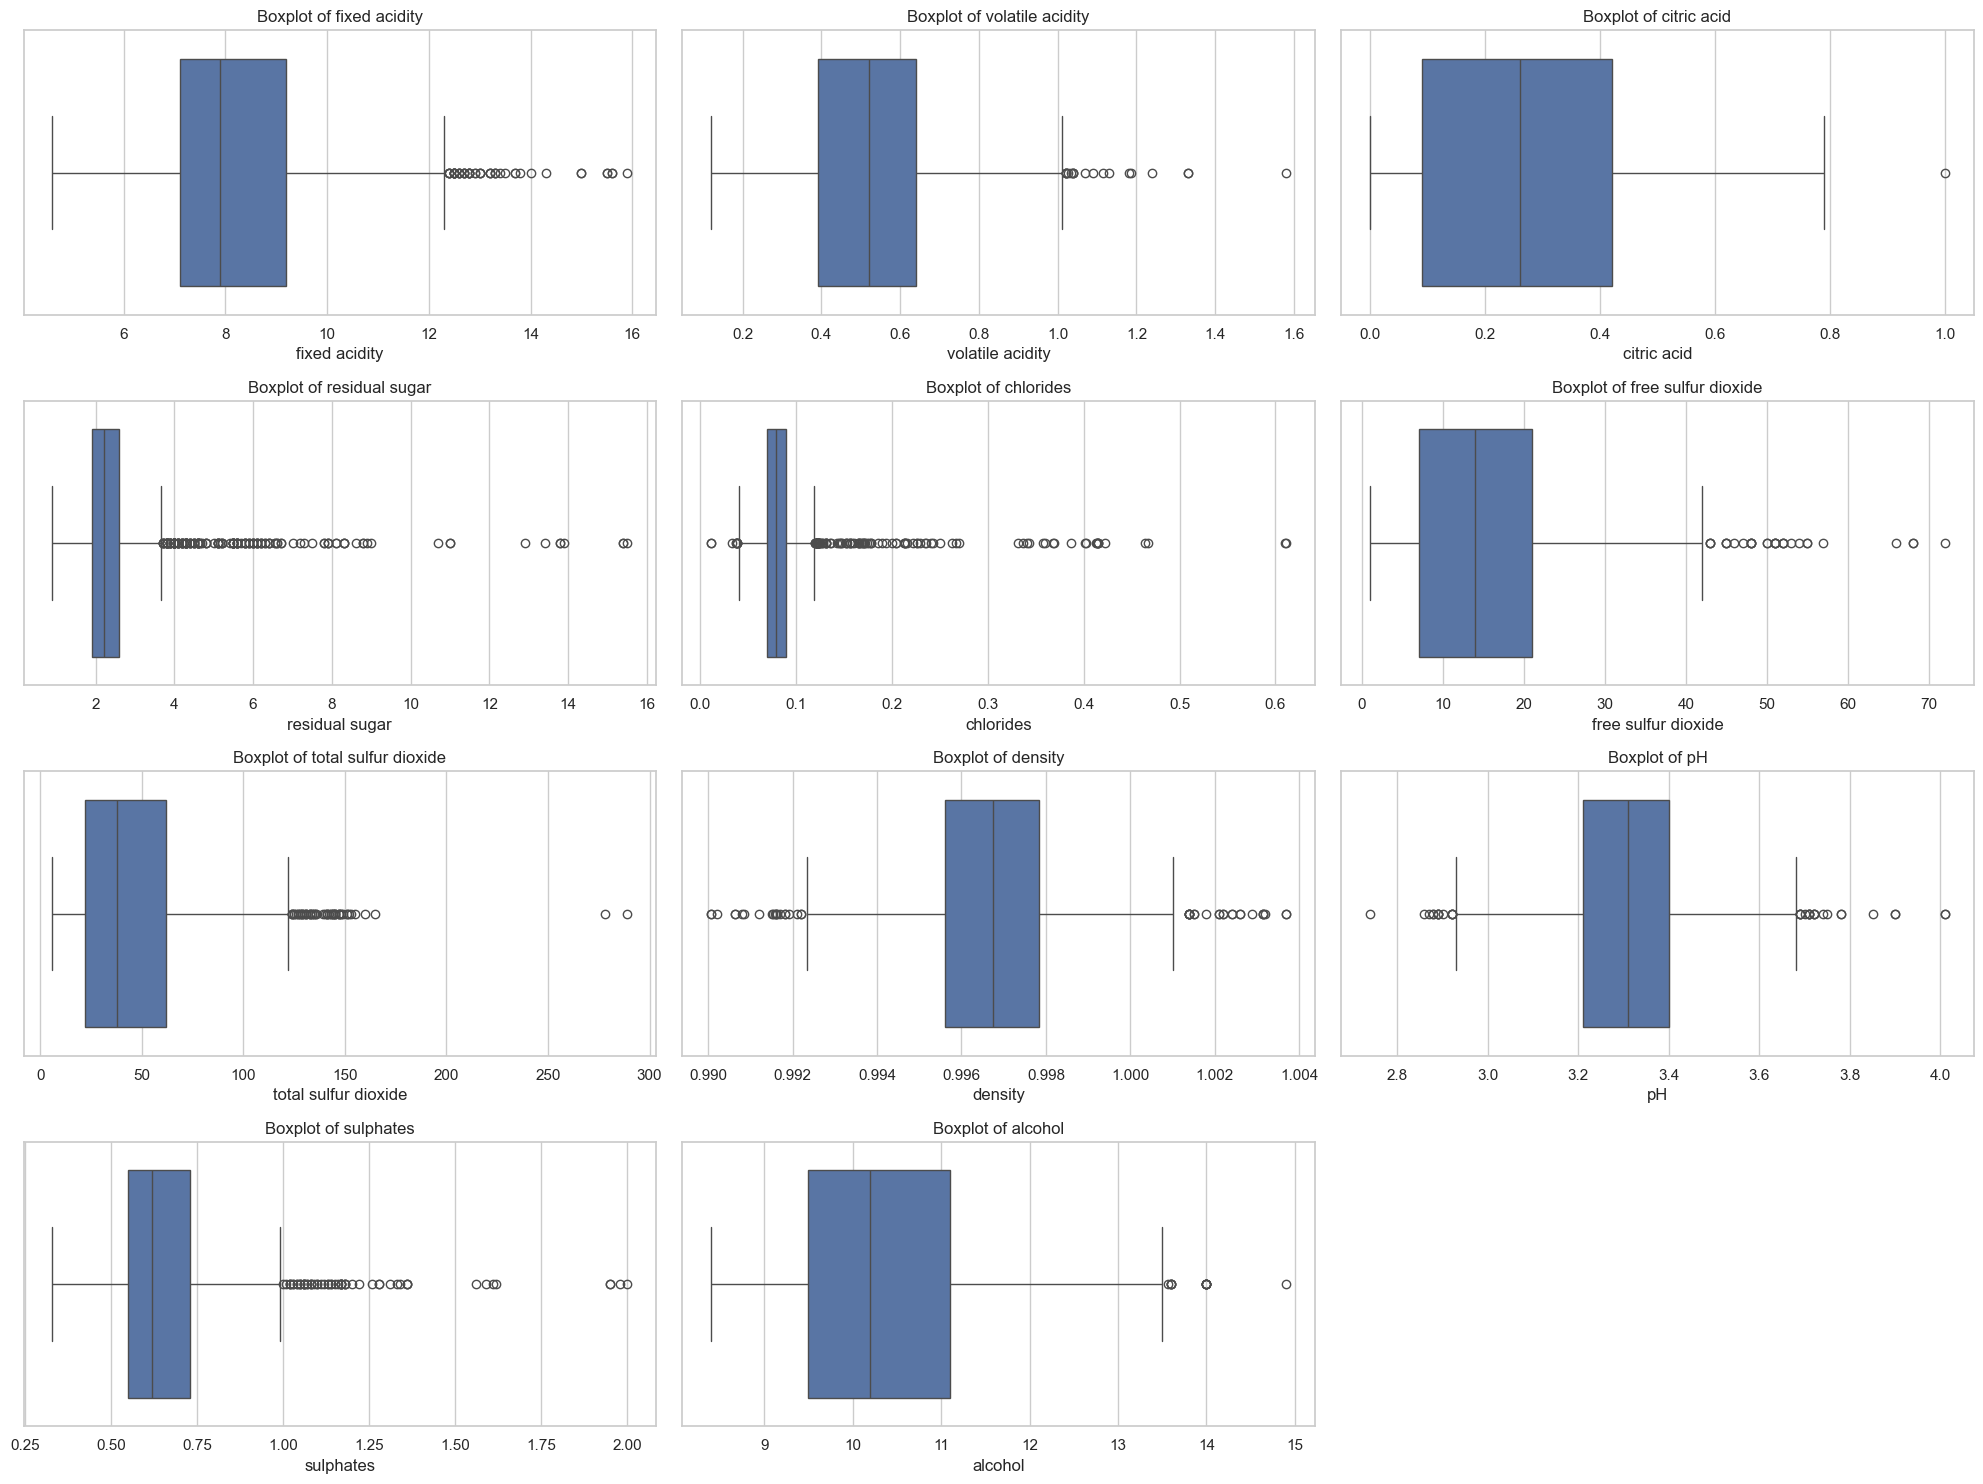

In [287]:
# Create boxplots for each feature
plt.figure(figsize=(20, 15))
for i, feature in enumerate(wine_data.columns[:-1]):  # Exclude 'quality' for boxplots
    plt.subplot(4, 3, i+1)
    sns.boxplot(x=wine_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

These box plots (short for 'box and whisker, referring to the blue box and two verticle lines) help us grasp variance across the columns.

A boxplot visually summarizes data distribution, with the box representing the middle 50% of values and the line inside showing the median. 
The whiskers (horizontal lines extending from the box) reach to the smallest and largest typical values, while circles mark unusual outliers. 

Boxplots make it easy to quickly compare distributions across different features, showing where most values cluster and highlighting any extreme values. 
When examining these wine quality plots, you can immediately see which features have wide or narrow ranges (citric acid is wide; sulphates is narrow), and which have many outliers.

Looking at them we can see that items like Citric Acid never land on a specific value across the set, whereas others like sulphates might have a strong core of typical values to establish a median (the blue box) but also have a high number of outliers (the little circles).

Let's now proceed to see how they correlate to one another. How closely is one rising or falling in value associated with each other feature?

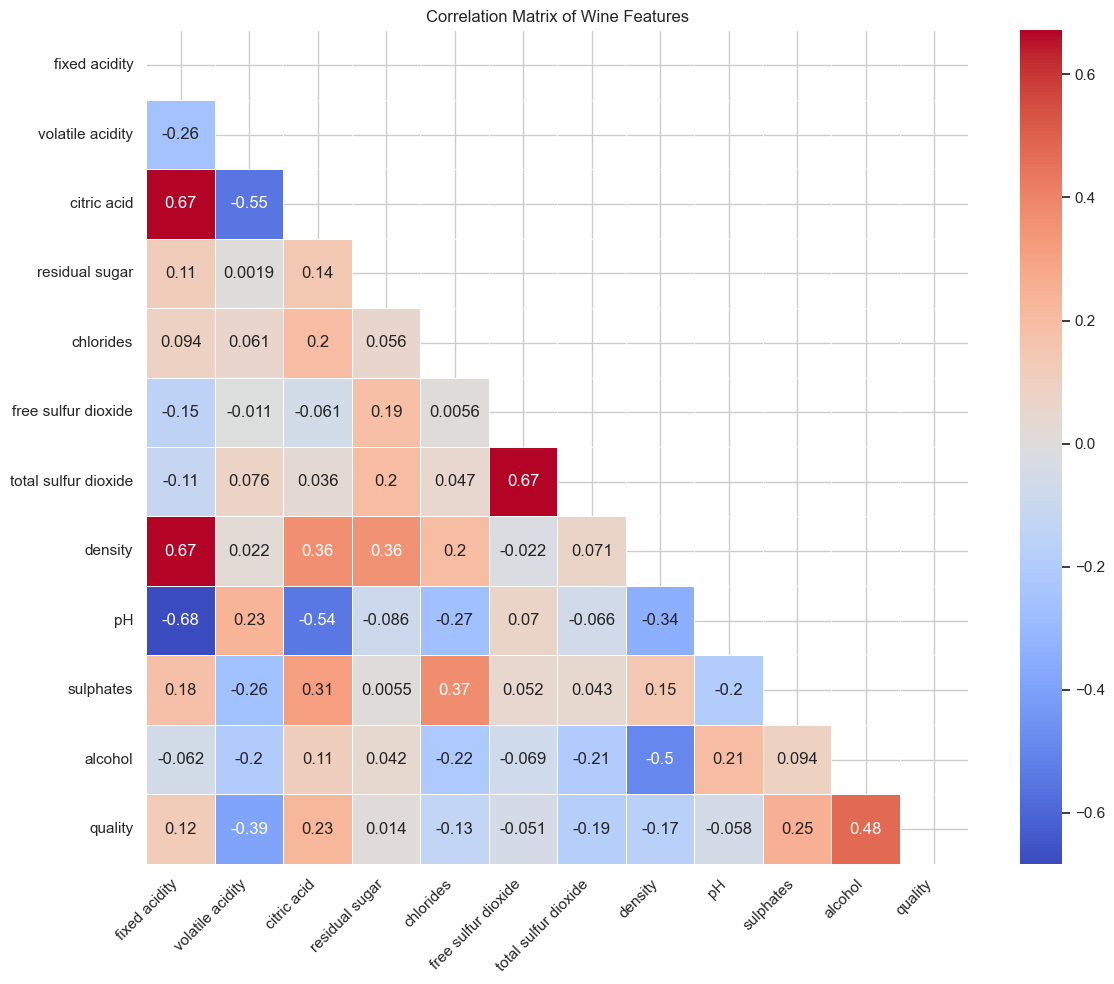

In [288]:
# Create a correlation matrix showing only the lower triangle
plt.figure(figsize=(12, 10))
correlation_matrix = wine_data.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the mask to the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)
plt.title('Correlation Matrix of Wine Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We can see a handful of pretty intuitive correlations, like those between citric acid and fixed. From the quality-alcohol correlation of 0.48 - quality's highest correlation - people seem to enjoy higher alcohol-by-volume wines, with their quality generally being ranked higher.

There are some other more surprising ones - like fixed acidity's correlation with density.

There are also some interesting absences of correlation. Volatile acidity and fixed acidity have a relatively weak correlation at -0.26 for two traits which share a noun. The same is true for Sulphates and both free and total sulfur dioxide, with correlations of 0.05 and 0.04 respectively.

For our research, the bottom most row 'quality' is of greatest interest. Let's break it out and look at this a little closer.

#### 2.2.2 Correlation with Quality

In [289]:
quality_correlation = correlation_matrix['quality'].sort_values(ascending=False)
print("\nFeatures sorted by correlation with quality:")
print(quality_correlation)


Features sorted by correlation with quality:
quality                 1.000
alcohol                 0.476
sulphates               0.251
citric acid             0.226
fixed acidity           0.124
residual sugar          0.014
free sulfur dioxide    -0.051
pH                     -0.058
chlorides              -0.129
density                -0.175
total sulfur dioxide   -0.185
volatile acidity       -0.391
Name: quality, dtype: float64


Since we are going to be training ensemble models to predict quality, if we aim for it to be accurate we will be looking for extremities - those with very high or very low correlation. 

For this reason, it would be wise to avoid including residual sugar, free sulphur dioxide, and pH in our analysis as their correlations with quality were near zero. 

Volatile acidity and alcohol ranked highest with correlations of -0.39 and 0.48 respectively.

<Figure size 1200x1000 with 0 Axes>

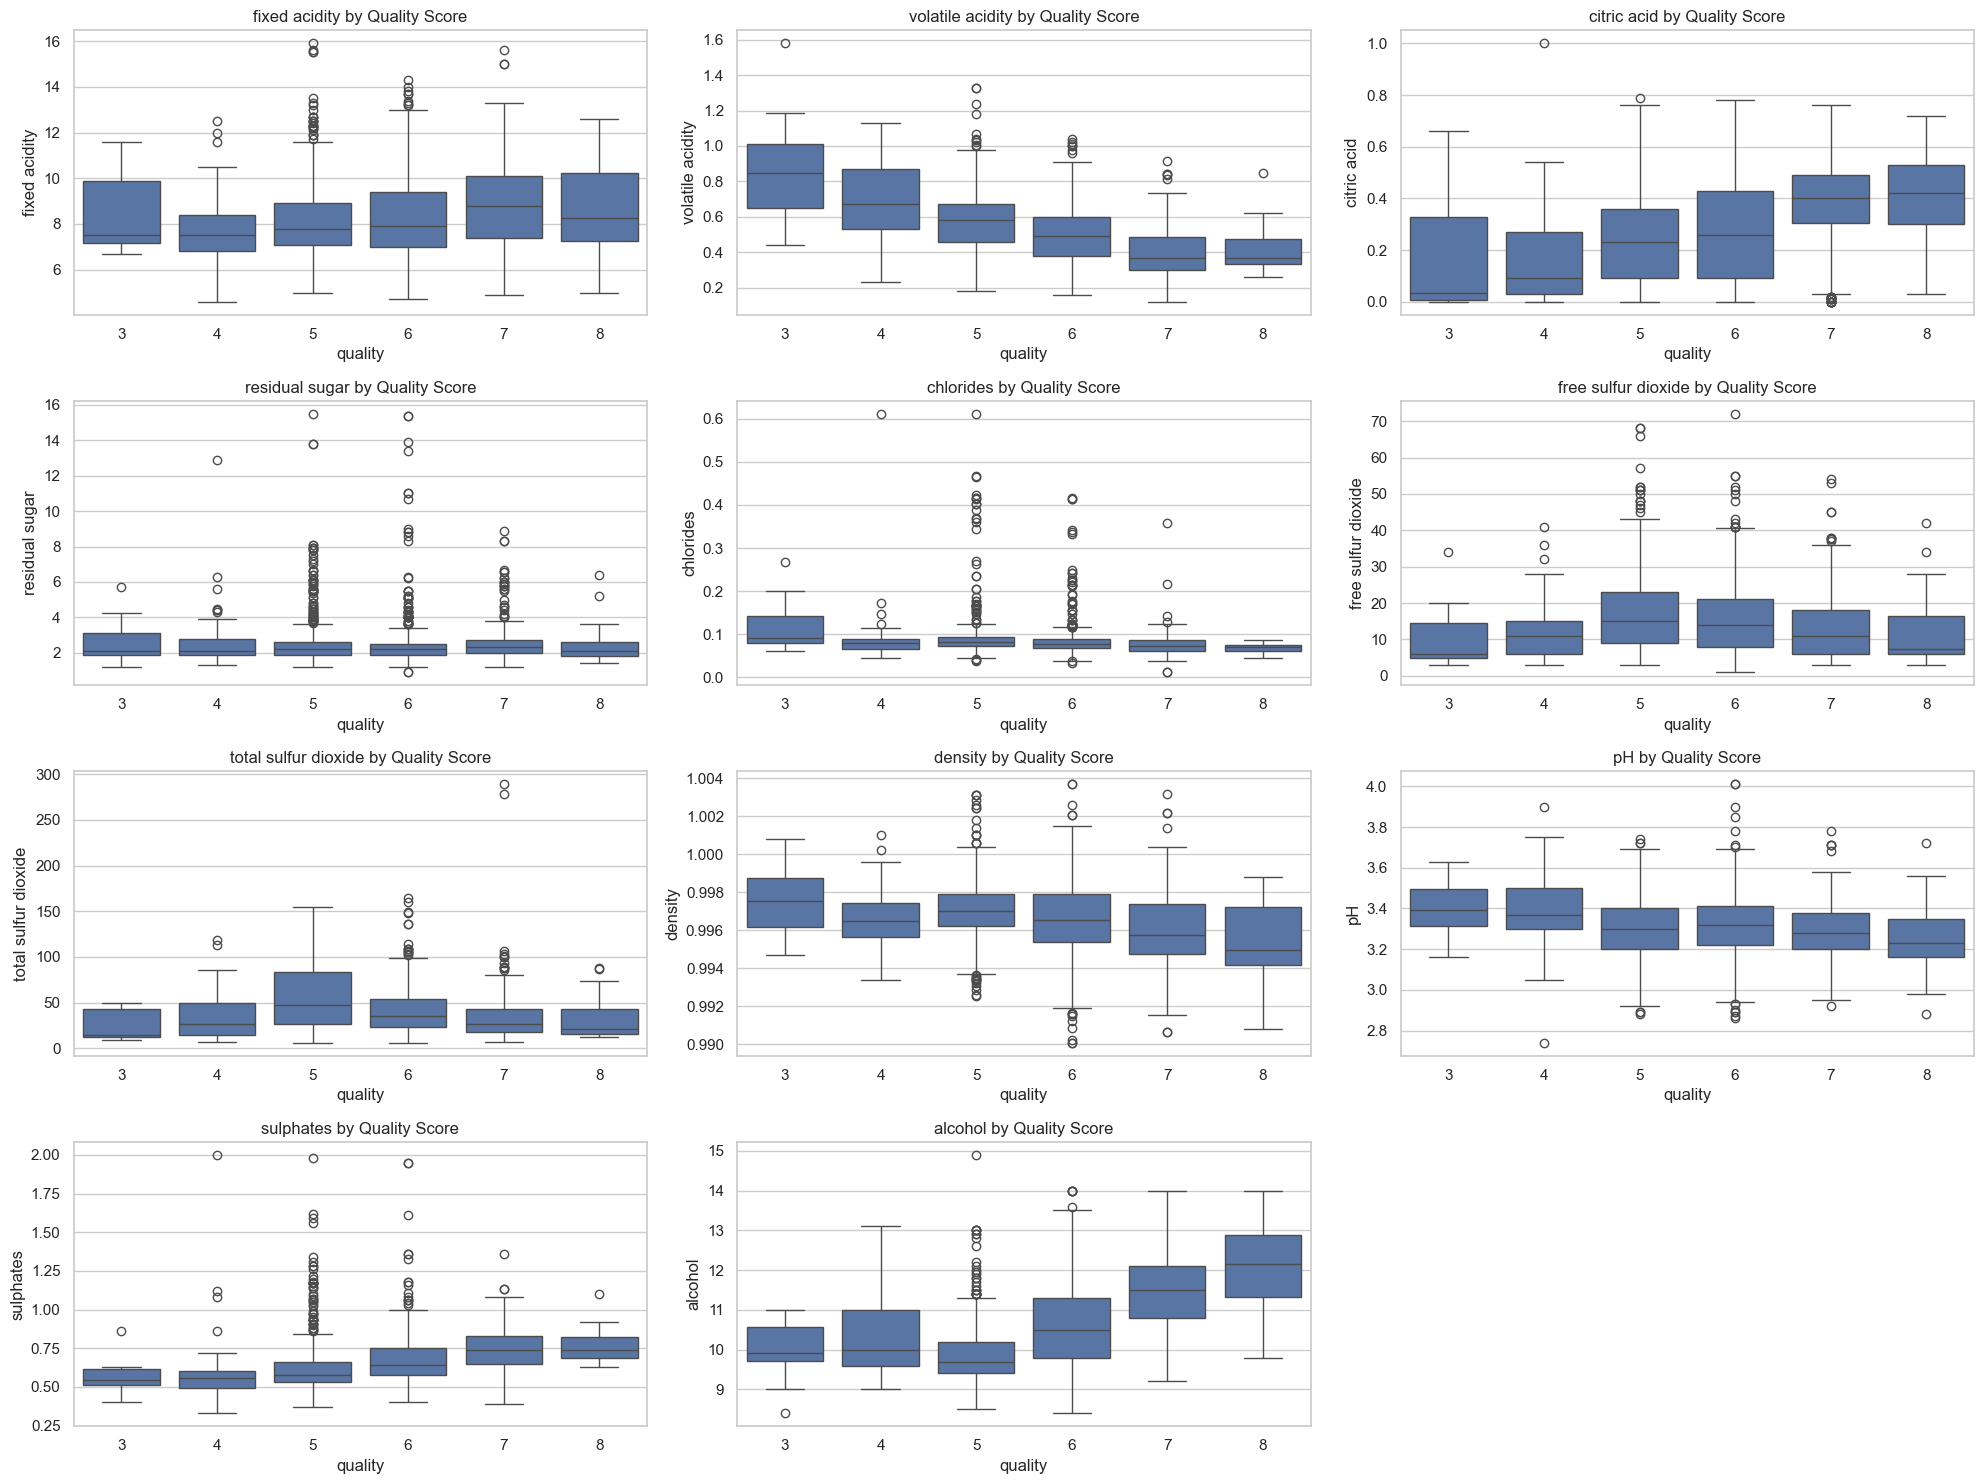

In [290]:
# Set the style for our plots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))




# Create boxplots for features grouped by quality
numeric_features = wine_data.columns[:-1]  # All features except quality
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='quality', y=feature, data=wine_data)
    plt.title(f'{feature} by Quality Score')
plt.tight_layout()
plt.show()


The boxplots depicts higher-rated wines consistently holding elevated alcohol content and reduced volatile acidity. 

Citric acid clearly trends upwards with quality, with a lot of low outliers in the 7 quality ranking.

#### 2.2.3 Quality Categorization

Now that we have a decent idea of how quality generally correlates with each column, we are going categorize quality. 

This dataset is tightly clustered around quality values of 5-6. Additionally, these values are integers, so on the whole 4-7 spectrum that leaves far less room to discrimiate difference.

By generalizing quality into bins, the model will have a better chance of selecting which bin - low, medium, or high quality - a wine belongs in.


Distribution of quality categories:
quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64

Percentage distribution:
quality_label
medium   82.489
high     13.571
low       3.940
Name: proportion, dtype: float64


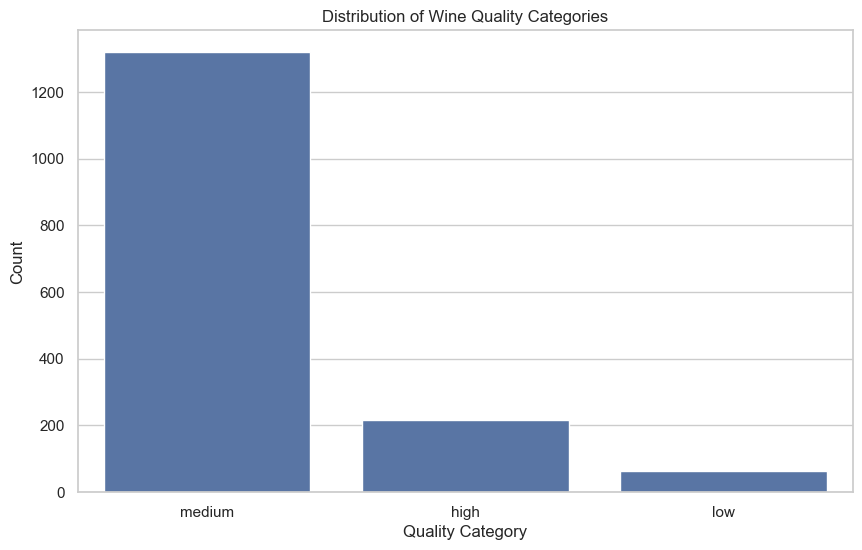

In [291]:
# Create quality categories (low, medium, high)
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

# Add the quality_label column
wine_data["quality_label"] = wine_data["quality"].apply(quality_to_label)




# Check the distribution of quality categories
print("\nDistribution of quality categories:")
print(wine_data["quality_label"].value_counts())
print("\nPercentage distribution:")
print(wine_data["quality_label"].value_counts(normalize=True) * 100)

# Visualize the distribution of quality categories
plt.figure(figsize=(10, 6))
sns.countplot(x='quality_label', data=wine_data)
plt.title('Distribution of Wine Quality Categories')
plt.xlabel('Quality Category')
plt.ylabel('Count')
plt.show()



As the quality column is integers rather than floats, and those integers are tightly clustered around values of 5-6, the medium class holds significant weight as a supermajority of the set. Would be nice if we had floats to tier out the quality into more classes, but alas.

Let's move on to translate these categories to numerical values consumable by the ensemble models we will be training.

In [292]:
# Create a mapping dictionary to verify consistency between the two categorization methods
category_mapping = {"low": 0, "medium": 1, "high": 2}


# Create numeric quality categories (0, 1, 2)
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2
    
wine_data["quality_numeric"] = wine_data["quality"].apply(quality_to_number)

# Check class distribution for the numeric categories
print("\nDistribution of numeric quality categories:")
print(wine_data["quality_numeric"].value_counts())
print("\nPercentage distribution:")
print(wine_data["quality_numeric"].value_counts(normalize=True) * 100)


# Check if the numeric categories match the label categories
wine_data["category_match"] = wine_data.apply(
    lambda row: category_mapping[row["quality_label"]] == row["quality_numeric"], 
    axis=1
)


Distribution of numeric quality categories:
quality_numeric
1    1319
2     217
0      63
Name: count, dtype: int64

Percentage distribution:
quality_numeric
1   82.489
2   13.571
0    3.940
Name: proportion, dtype: float64


These values look right, but let's depict the numeric and label ones side by side graphically to be certain.


Percentage of matching categories: 100.00%
Number of mismatches: 0


<Figure size 1000x600 with 0 Axes>

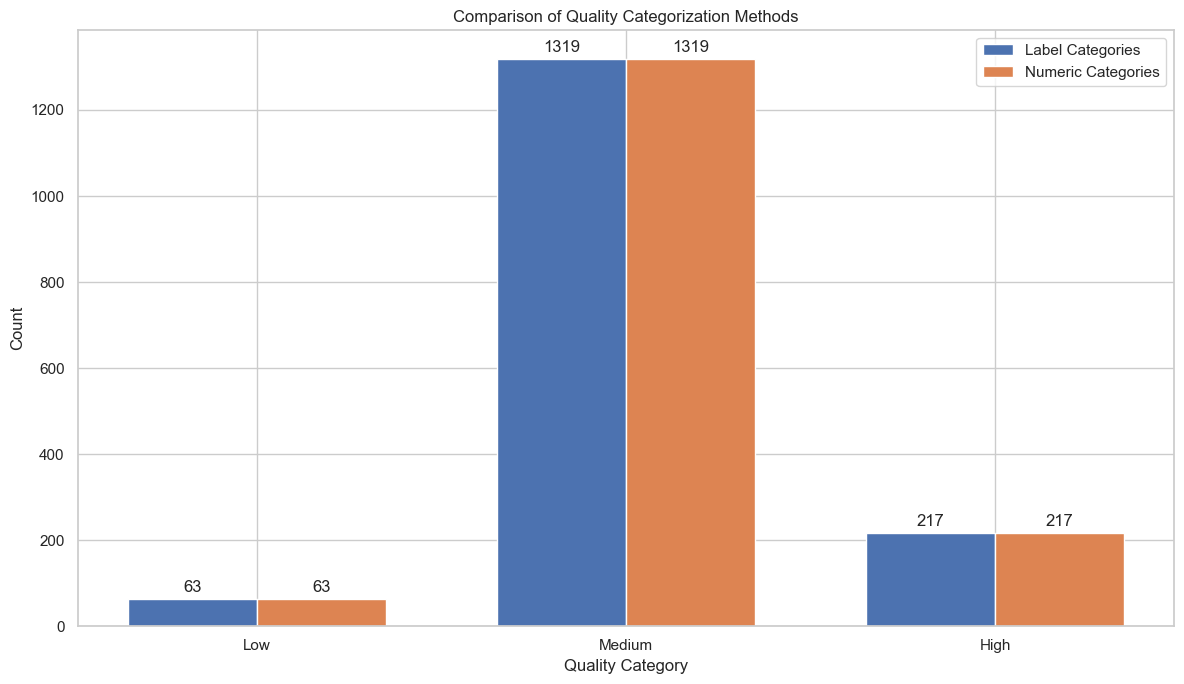

In [293]:


# Display the verification results
match_percentage = (wine_data["category_match"].sum() / len(wine_data)) * 100
print(f"\nPercentage of matching categories: {match_percentage:.2f}%")
print(f"Number of mismatches: {len(wine_data) - wine_data['category_match'].sum()}")

# If there are any mismatches, display them
if not wine_data["category_match"].all():
    print("\nMismatched entries:")
    print(wine_data[~wine_data["category_match"]][["quality", "quality_label", "quality_numeric"]])

# Visualize the distribution of both categorization methods in one chart
plt.figure(figsize=(10, 6))

# Create a DataFrame for plotting
categories = ['Low', 'Medium', 'High'] 
label_counts = [
    wine_data[wine_data['quality_label'] == 'low'].shape[0],
    wine_data[wine_data['quality_label'] == 'medium'].shape[0],
    wine_data[wine_data['quality_label'] == 'high'].shape[0]
]
numeric_counts = [
    wine_data[wine_data['quality_numeric'] == 0].shape[0],
    wine_data[wine_data['quality_numeric'] == 1].shape[0],
    wine_data[wine_data['quality_numeric'] == 2].shape[0]
]

# Set up bar positions
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, label_counts, width, label='Label Categories')
rects2 = ax.bar(x + width/2, numeric_counts, width, label='Numeric Categories')

# Add labels and title
ax.set_xlabel('Quality Category')
ax.set_ylabel('Count')
ax.set_title('Comparison of Quality Categorization Methods')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

# Drop the verification column as it's no longer needed
wine_data.drop("category_match", axis=1, inplace=True)

We have a match! The label and numeric counts match and we are good to begin processing them.

## 3. Feature Selection and Justification

### 3.1 Analyze Feature Importance

Previously in section 2.2.2, we established Volatile acidity and alcohol ranked highest with correlations of -0.39 and 0.48 respectively. My goal is that with a comparably strong negative and strong positive correlation, the model will be able to successfully predict which of the 3 quality labels a wine belongs in.

I investigated other variables to see if there were any that had a high correlation with numeric quality, but a low correlation with the other two I intend to use.

In [294]:
def analyze_feature_importance(data, features_list, primary_features, target='quality'):
    """
    Analyzes feature importance based on correlation with target and combined correlation with primary features.
    """
    # Create a copy with only numeric columns for correlation calculation
    numeric_data = data.select_dtypes(include=['number'])
    
    # Calculate absolute correlation matrix
    corr_matrix = numeric_data.corr().abs()
    
    # Create a list to store results
    results_list = []
    
    for feature in features_list:
        # Skip if feature is already in primary features
        if feature in primary_features:
            continue
            
        # Get absolute correlation with quality
        quality_corr = corr_matrix.loc[feature, target]
        
        # Calculate combined correlation with primary features
        primary_corrs = [corr_matrix.loc[feature, pf] for pf in primary_features]
        combined_corr = sum(primary_corrs) / len(primary_corrs)
        
        # Add to results
        results_list.append({
            'Feature': feature,
            'Quality Correlation': quality_corr,
            'Primary Correlation': combined_corr
        })
    
    # Create DataFrame from list
    results = pd.DataFrame(results_list)
    
    if len(results) == 0:
        print("No valid features found to analyze. Check feature names.")
        return pd.DataFrame(), pd.DataFrame()
    
    # Create the two sorted tables
    quality_sorted = results.sort_values('Quality Correlation', ascending=False).reset_index(drop=True)
    independence_sorted = results.sort_values('Primary Correlation', ascending=True).reset_index(drop=True)
    
    return quality_sorted, independence_sorted

# Define the features we want to analyze - use exact column names from your dataframe
filtered_features = ['citric acid', 'total sulfur dioxide', 'density', 'sulphates']
primary_features = ['volatile acidity', 'alcohol']

try:
    # Calculate the tables
    quality_sorted, combined_sorted = analyze_feature_importance(wine_data, filtered_features, primary_features)
    
    # Display the tables with formatting to 3 decimal places
    pd.set_option('display.float_format', '{:.3f}'.format)
    
    if not quality_sorted.empty:
        print("Features Ranked by Quality Correlation (Highest to Lowest):")
        print(quality_sorted)
        print("\nFeatures Ranked by Primary Correlation (Lowest to Highest):")
        print(combined_sorted)
except Exception as e:
    print(f"Error occurred: {e}")
    
    # Let's debug by examining column names
    print("\nActual column names in dataset:")
    print(wine_data.columns.tolist())
    
    # Check data types
    print("\nData types:")
    print(wine_data.dtypes)

Features Ranked by Quality Correlation (Highest to Lowest):
                Feature  Quality Correlation  Primary Correlation
0             sulphates                0.251                0.177
1           citric acid                0.226                0.331
2  total sulfur dioxide                0.185                0.141
3               density                0.175                0.259

Features Ranked by Primary Correlation (Lowest to Highest):
                Feature  Quality Correlation  Primary Correlation
0  total sulfur dioxide                0.185                0.141
1             sulphates                0.251                0.177
2               density                0.175                0.259
3           citric acid                0.226                0.331


### 3.2 Define input features and target

Our feature analysis has distilled the essence of wine quality prediction to just two key variables: alcohol content and volatile acidity. These attributes demonstrate the strongest correlations with perceived quality, providing a solid foundation for our modeling. 

In [295]:
# Define input features (X) and target (y)
X = wine_data[['volatile acidity', 'alcohol']]  # Features
y = wine_data['quality_label']  # Target - using text categories instead of numeric

# Display shapes to verify
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Display the first few rows of X and y to verify
print("\nFirst few rows of features (X) and target (y):")
print(X.head())
print("\nTarget classes:")
print(y.head())

# Display class distribution
print("\nClass distribution:")
print(y.value_counts())
print("\nPercentage distribution:")
print(y.value_counts(normalize=True) * 100)

X shape: (1599, 2)
y shape: (1599,)

First few rows of features (X) and target (y):
   volatile acidity  alcohol
0             0.700    9.400
1             0.880    9.800
2             0.760    9.800
3             0.280    9.800
4             0.700    9.400

Target classes:
0    medium
1    medium
2    medium
3    medium
4    medium
Name: quality_label, dtype: object

Class distribution:
quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64

Percentage distribution:
quality_label
medium   82.489
high     13.571
low       3.940
Name: proportion, dtype: float64


## 4. Split the Data into Train and Test

### 4.1 Create train-test split

Now we will move on to split up the data for testing and training the model. We are going to stratify it to ensure the splits end up with equal low/medium/high datasets, since they are highly imbalanced (at ~4/82/14% respectively). This ensures both the test and training set maintain this distribution, which is critical for properly evaluating how well the models perform on the underrepresented low and high quality wines.

In [296]:
# Train/test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,              # 80% train, 20% test
    random_state=state_setter,            # For reproducibility
    stratify=y                  # Maintain class distribution in both sets
)



### 4.2 Verify split characteristics
Let's confirm our split worked as intended.

In [297]:
# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify stratification worked by checking class distribution
print("\nOriginal class distribution:")
print(y.value_counts(normalize=True) * 100)

print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True) * 100)

X_train shape: (1279, 2)
X_test shape: (320, 2)
y_train shape: (1279,)
y_test shape: (320,)

Original class distribution:
quality_label
medium   82.489
high     13.571
low       3.940
Name: proportion, dtype: float64

Training set class distribution:
quality_label
medium   82.486
high     13.604
low       3.909
Name: proportion, dtype: float64

Test set class distribution:
quality_label
medium   82.500
high     13.438
low       4.062
Name: proportion, dtype: float64


The raw counts look good, but let's double check the actual percentages across the original set, the train set, and the test set.

In [298]:
# Get class counts
classes = ['low', 'medium', 'high']
original_counts = [sum(wine_data['quality_label'] == cls) for cls in classes]
train_counts = [sum(y_train == cls) for cls in classes]
test_counts = [sum(y_test == cls) for cls in classes]

# Calculate percentages
total_count = len(wine_data)
train_total = len(y_train)
test_total = len(y_test)

original_percentages = [count/total_count*100 for count in original_counts]
train_percentages = [count/train_total*100 for count in train_counts]
test_percentages = [count/test_total*100 for count in test_counts]

# Calculate percentage differences
train_percentage_diffs = [train_p - orig_p for train_p, orig_p in zip(train_percentages, original_percentages)]
test_percentage_diffs = [test_p - orig_p for test_p, orig_p in zip(test_percentages, original_percentages)]

# Table 1: Raw Counts
counts_df = pd.DataFrame({
    'class_name': classes,
    'original_class_count': original_counts,
    'train_count': train_counts,
    'test_count': test_counts
})


# Display the tables
print("Table 1: Wine Quality Class Counts")
print(counts_df.to_string(index=False))



Table 1: Wine Quality Class Counts
class_name  original_class_count  train_count  test_count
       low                    63           50          13
    medium                  1319         1055         264
      high                   217          174          43


In [299]:
# Table 2: Percentages
percentages_df = pd.DataFrame({
    'class_name': classes,
    'original_percentage': [f"{p:.2f}%" for p in original_percentages],
    'train_percentage': [f"{p:.2f}%" for p in train_percentages],
    'test_percentage': [f"{p:.2f}%" for p in test_percentages]
})



print("\nTable 2: Wine Quality Class Percentages")
print(percentages_df.to_string(index=False))


Table 2: Wine Quality Class Percentages
class_name original_percentage train_percentage test_percentage
       low               3.94%            3.91%           4.06%
    medium              82.49%           82.49%          82.50%
      high              13.57%           13.60%          13.44%


In [300]:
# Table 3: Percentage Differences
differences_df = pd.DataFrame({
    'class_name': classes,
    'train_percentage_difference': [f"{p:.2f}%" for p in train_percentage_diffs],
    'test_percentage_difference': [f"{p:.2f}%" for p in test_percentage_diffs]
})

print("\nTable 3: Percentage Differences (Split vs Original)")
print(differences_df.to_string(index=False))


Table 3: Percentage Differences (Split vs Original)
class_name train_percentage_difference test_percentage_difference
       low                      -0.03%                      0.12%
    medium                      -0.00%                      0.01%
      high                       0.03%                     -0.13%


Looks good! Our test and train distributions have put each quality class near a 0.1% difference from the original distribution. Time to move on to training.

## 5.  Evaluate Models & Compare
Let's get set up and start feeding this data to our models.

### 5.1 Helper Function

Here we will implement a helper function to feed any of the models the data they need, and then proceed to feed it into the models. This model ensures we 

In [301]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    # Calculate metrics
    train_precision = precision_score(y_train, y_train_pred, average="weighted", zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, average="weighted", zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average="weighted", zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average="weighted", zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted", zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted", zero_division=0)

    
    # Calculate gaps (to measure overfitting)
    acc_gap = train_acc - test_acc
    precision_gap = train_precision - test_precision
    recall_gap = train_recall - test_recall
    f1_gap = train_f1 - test_f1
    
    # Print results
    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred, labels=['low', 'medium', 'high']))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Gap: {acc_gap:.4f}")
    print(f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}, Gap: {precision_gap:.4f}")
    print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}, Gap: {recall_gap:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}, Gap: {f1_gap:.4f}")
    
    # Store results
    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Accuracy Gap": acc_gap,
        "Train Precision": train_precision,
        "Test Precision": test_precision,
        "Precision Gap": precision_gap,
        "Train Recall": train_recall,
        "Test Recall": test_recall,
        "Recall Gap": recall_gap,
        "Train F1": train_f1,
        "Test F1": test_f1,
        "F1 Gap": f1_gap
    })

### 5.2 Train models

At long last! Let's proceed to train the models and look at their basic results.

#### 5.2.1 Train Random Forest (100), Random Forest (200, max_depth=10), and AdaBoost (100)

In [302]:
# Initialize results list
results = []

# 1. Random Forest
evaluate_model(
    "Random Forest (100)",
    RandomForestClassifier(n_estimators=100, random_state=state_setter),
    X_train,
    y_train,
    X_test,
    y_test,
    results
)

# 2. Random Forest (200, max depth=10) 
evaluate_model(
    "Random Forest (200, max_depth=10)",
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=state_setter),
    X_train,
    y_train,
    X_test,
    y_test,
    results
)

# 3. AdaBoost 
evaluate_model(
    "AdaBoost (100)",
    AdaBoostClassifier(n_estimators=100, random_state=state_setter),
    X_train,
    y_train,
    X_test,
    y_test,
    results
)






Random Forest (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  2 245  17]
 [  0  20  23]]
Train Accuracy: 0.9672, Test Accuracy: 0.8375, Gap: 0.1297
Train Precision: 0.9669, Test Precision: 0.8043, Gap: 0.1626
Train Recall: 0.9672, Test Recall: 0.8375, Gap: 0.1297
Train F1 Score: 0.9669, Test F1 Score: 0.8203, Gap: 0.1466

Random Forest (200, max_depth=10) Results
Confusion Matrix (Test):
[[  0  12   1]
 [  1 250  13]
 [  0  24  19]]
Train Accuracy: 0.9304, Test Accuracy: 0.8406, Gap: 0.0898
Train Precision: 0.9315, Test Precision: 0.7985, Gap: 0.1330
Train Recall: 0.9304, Test Recall: 0.8406, Gap: 0.0898
Train F1 Score: 0.9248, Test F1 Score: 0.8172, Gap: 0.1076

AdaBoost (100) Results
Confusion Matrix (Test):
[[  0  12   1]
 [  0 240  24]
 [  0  21  22]]
Train Accuracy: 0.8280, Test Accuracy: 0.8187, Gap: 0.0092
Train Precision: 0.7912, Test Precision: 0.7882, Gap: 0.0030
Train Recall: 0.8280, Test Recall: 0.8187, Gap: 0.0092
Train F1 Score: 0.8090, Test F1 Score: 0.8031, G

#### 5.2.2 Train AdaBoost (200, lr=0.5), Gradient Boosting, and Voting Classifier (DT, SVM, NN)

In [303]:
# 4. AdaBoost (200, lr=0.5) 
evaluate_model(
    "AdaBoost (200, lr=0.5)",
    AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=state_setter),
    X_train,
    y_train,
    X_test,
    y_test,
    results
)

# 5. Gradient Boosting
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=state_setter
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results
)

# 6. Voting Classifier (DT, SVM, NN) 
voting1 = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier(random_state=state_setter)),
        ("SVM", SVC(probability=True, random_state=state_setter)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=state_setter)),
    ],
    voting="soft"
)
evaluate_model(
    "Voting (DT + SVM + NN)",
    voting1,
    X_train,
    y_train,
    X_test,
    y_test,
    results
)




AdaBoost (200, lr=0.5) Results
Confusion Matrix (Test):
[[  0  12   1]
 [  0 248  16]
 [  0  30  13]]
Train Accuracy: 0.8382, Test Accuracy: 0.8156, Gap: 0.0225
Train Precision: 0.7891, Test Precision: 0.7637, Gap: 0.0253
Train Recall: 0.8382, Test Recall: 0.8156, Gap: 0.0225
Train F1 Score: 0.8073, Test F1 Score: 0.7865, Gap: 0.0208

Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  2 245  17]
 [  0  29  14]]
Train Accuracy: 0.8874, Test Accuracy: 0.8094, Gap: 0.0780
Train Precision: 0.8847, Test Precision: 0.7650, Gap: 0.1198
Train Recall: 0.8874, Test Recall: 0.8094, Gap: 0.0780
Train F1 Score: 0.8736, Test F1 Score: 0.7845, Gap: 0.0891

Voting (DT + SVM + NN) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  1 256   7]
 [  0  28  15]]
Train Accuracy: 0.8851, Test Accuracy: 0.8469, Gap: 0.0382
Train Precision: 0.8991, Test Precision: 0.8027, Gap: 0.0964
Train Recall: 0.8851, Test Recall: 0.8469, Gap: 0.0382
Train F1 Score: 0.8554, Test F1 Score: 0.8150, 

#### 5.2.3 Train Voting Classifier (RF, LR, KNN), Bagging, and MLP

In [304]:
# 7. Voting Classifier (RF, LR, KNN) 
voting2 = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=100, random_state=state_setter)),
        ("LR", LogisticRegression(max_iter=1000, random_state=state_setter)),
        ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ],
    voting="soft"
)
evaluate_model(
    "Voting (RF + LR + KNN)",
    voting2,
    X_train,
    y_train,
    X_test,
    y_test,
    results
)

# 8. Bagging 
evaluate_model(
    "Bagging (DT, 100)",
    BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=state_setter),
        n_estimators=100,
        random_state=state_setter
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results
)

# 9. MLP Classifier 
evaluate_model(
    "MLP Classifier",
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=state_setter),
    X_train,
    y_train,
    X_test,
    y_test,
    results
)


Voting (RF + LR + KNN) Results
Confusion Matrix (Test):
[[  0  12   1]
 [  1 249  14]
 [  0  28  15]]
Train Accuracy: 0.8913, Test Accuracy: 0.8250, Gap: 0.0663
Train Precision: 0.8881, Test Precision: 0.7780, Gap: 0.1101
Train Recall: 0.8913, Test Recall: 0.8250, Gap: 0.0663
Train F1 Score: 0.8715, Test F1 Score: 0.7982, Gap: 0.0733

Bagging (DT, 100) Results
Confusion Matrix (Test):
[[  0  12   1]
 [  3 242  19]
 [  0  21  22]]
Train Accuracy: 0.9672, Test Accuracy: 0.8250, Gap: 0.1422
Train Precision: 0.9671, Test Precision: 0.7964, Gap: 0.1707
Train Recall: 0.9672, Test Recall: 0.8250, Gap: 0.1422
Train F1 Score: 0.9668, Test F1 Score: 0.8104, Gap: 0.1565

MLP Classifier Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 257   7]
 [  0  33  10]]
Train Accuracy: 0.8335, Test Accuracy: 0.8344, Gap: -0.0009
Train Precision: 0.8159, Test Precision: 0.7788, Gap: 0.0371
Train Recall: 0.8335, Test Recall: 0.8344, Gap: -0.0009
Train F1 Score: 0.7875, Test F1 Score: 0.7927, Gap: -0.0052

### 5.3 All Model Comparison

The comparative analysis will now examine our ensemble models through multiple performance lenses - accuracy, precision, recall, and F1 score - with particular attention to the gap between training and testing performance. Through visual comparison across these metrics, we can check which approaches best generalize to new data while avoiding overfitting. This will help us the best two models to compare in detail.

In [305]:
# Convert results to DataFrame and sort by test accuracy
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Test Accuracy", ascending=False)
print("\nSummary of All Models (Sorted by Test Accuracy):")
display(results_df)


Summary of All Models (Sorted by Test Accuracy):


,Model,Train Accuracy,Test Accuracy,Accuracy Gap,Train Precision,Test Precision,Precision Gap,Train Recall,Test Recall,Recall Gap,Train F1,Test F1,F1 Gap
5,Voting (DT + SVM + NN),0.885,0.847,0.038,0.899,0.803,0.096,0.885,0.847,0.038,0.855,0.815,0.040
1,"Random Forest (200, max_depth=10)",0.930,0.841,0.090,0.931,0.799,0.133,0.930,0.841,0.090,0.925,0.817,0.108
0,Random Forest (100),0.967,0.838,0.130,0.967,0.804,0.163,0.967,0.838,0.130,0.967,0.820,0.147
8,MLP Classifier,0.833,0.834,-0.001,0.816,0.779,0.037,0.833,0.834,-0.001,0.787,0.793,-0.005
6,Voting (RF + LR + KNN),0.891,0.825,0.066,0.888,0.778,0.110,0.891,0.825,0.066,0.872,0.798,0.073
7,"Bagging (DT, 100)",0.967,0.825,0.142,0.967,0.796,0.171,0.967,0.825,0.142,0.967,0.810,0.156
2,AdaBoost (100),0.828,0.819,0.009,0.791,0.788,0.003,0.828,0.819,0.009,0.809,0.803,0.006
3,"AdaBoost (200, lr=0.5)",0.838,0.816,0.023,0.789,0.764,0.025,0.838,0.816,0.023,0.807,0.786,0.021
4,Gradient Boosting (100),0.887,0.809,0.078,0.885,0.765,0.120,0.887,0.809,0.078,0.874,0.785,0.089


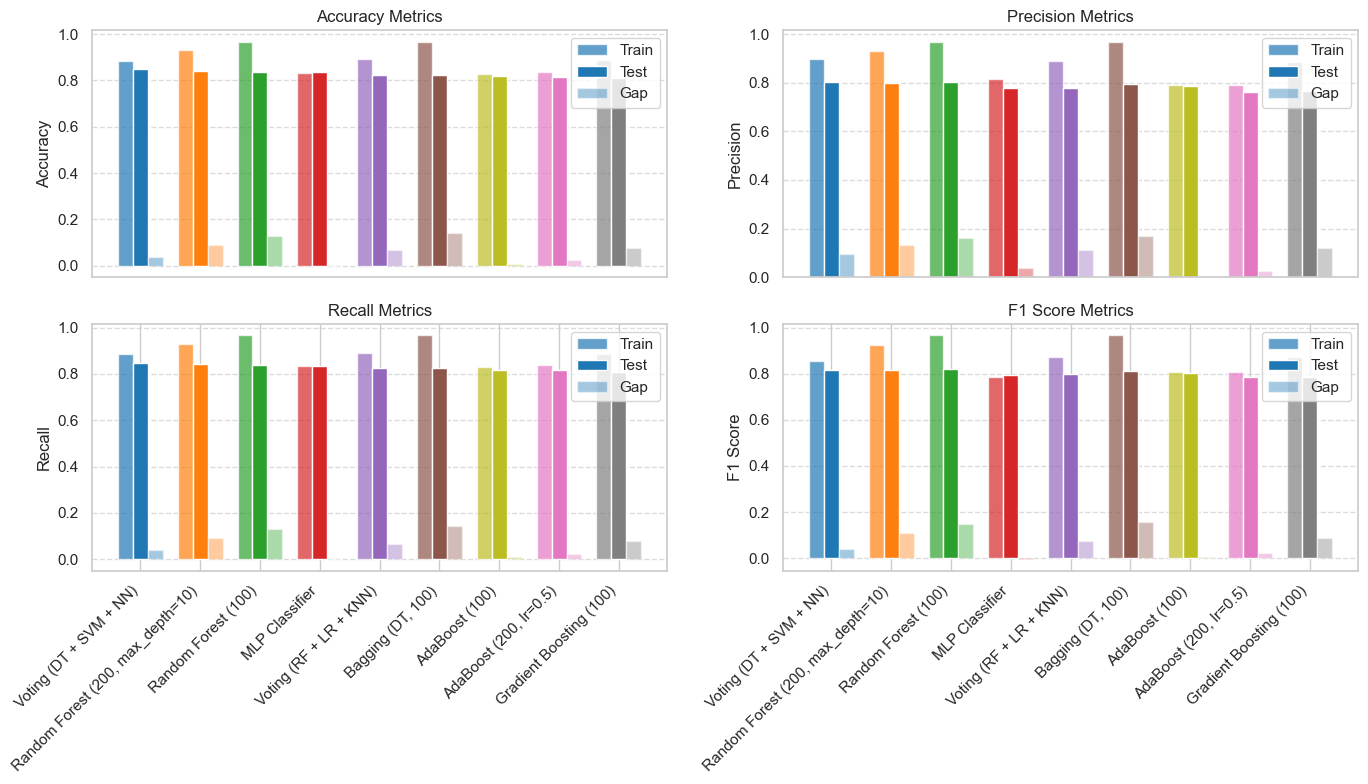

In [306]:
# Set up consistent colors for each model to use across all charts
model_colors = {
    "Voting (DT + SVM + NN)": "#1f77b4",
    "Random Forest (200, max_depth=10)": "#ff7f0e",
    "Random Forest (100)": "#2ca02c",
    "MLP Classifier": "#d62728",
    "Voting (RF + LR + KNN)": "#9467bd",
    "Bagging (DT, 100)": "#8c564b",
    "AdaBoost (200, lr=0.5)": "#e377c2",
    "Gradient Boosting (100)": "#7f7f7f",
    "AdaBoost (100)": "#bcbd22"
}

# Sort models by test accuracy for consistent ordering
sorted_results = results_df.sort_values('Test Accuracy', ascending=False)
model_names = sorted_results['Model']
x = np.arange(len(model_names))
width = 0.25  # Slightly wider bars

# Create 4 separate figures for the different metric groups
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
# Accuracy metrics
for i, model in enumerate(model_names):
    row = sorted_results[sorted_results['Model'] == model].iloc[0]
    plt.bar(i-width, row['Train Accuracy'], width, color=model_colors[model], alpha=0.7, label=model if i == 0 else "")
    plt.bar(i, row['Test Accuracy'], width, color=model_colors[model], label="")
    plt.bar(i+width, row['Accuracy Gap'], width, color=model_colors[model], alpha=0.4, label="")

plt.ylabel('Accuracy')
plt.title('Accuracy Metrics')
plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Train', 'Test', 'Gap'], loc='upper right')

plt.subplot(2, 2, 2)
# Precision metrics
for i, model in enumerate(model_names):
    row = sorted_results[sorted_results['Model'] == model].iloc[0]
    plt.bar(i-width, row['Train Precision'], width, color=model_colors[model], alpha=0.7)
    plt.bar(i, row['Test Precision'], width, color=model_colors[model])
    plt.bar(i+width, row['Precision Gap'], width, color=model_colors[model], alpha=0.4)

plt.ylabel('Precision')
plt.title('Precision Metrics')
plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Train', 'Test', 'Gap'], loc='upper right')

plt.subplot(2, 2, 3)
# Recall metrics
for i, model in enumerate(model_names):
    row = sorted_results[sorted_results['Model'] == model].iloc[0]
    plt.bar(i-width, row['Train Recall'], width, color=model_colors[model], alpha=0.7)
    plt.bar(i, row['Test Recall'], width, color=model_colors[model])
    plt.bar(i+width, row['Recall Gap'], width, color=model_colors[model], alpha=0.4)

plt.ylabel('Recall')
plt.title('Recall Metrics')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Train', 'Test', 'Gap'], loc='upper right')

plt.subplot(2, 2, 4)
# F1 metrics
for i, model in enumerate(model_names):
    row = sorted_results[sorted_results['Model'] == model].iloc[0]
    plt.bar(i-width, row['Train F1'], width, color=model_colors[model], alpha=0.7)
    plt.bar(i, row['Test F1'], width, color=model_colors[model])
    plt.bar(i+width, row['F1 Gap'], width, color=model_colors[model], alpha=0.4)

plt.ylabel('F1 Score')
plt.title('F1 Score Metrics')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Train', 'Test', 'Gap'], loc='upper right')

plt.tight_layout()
plt.show()



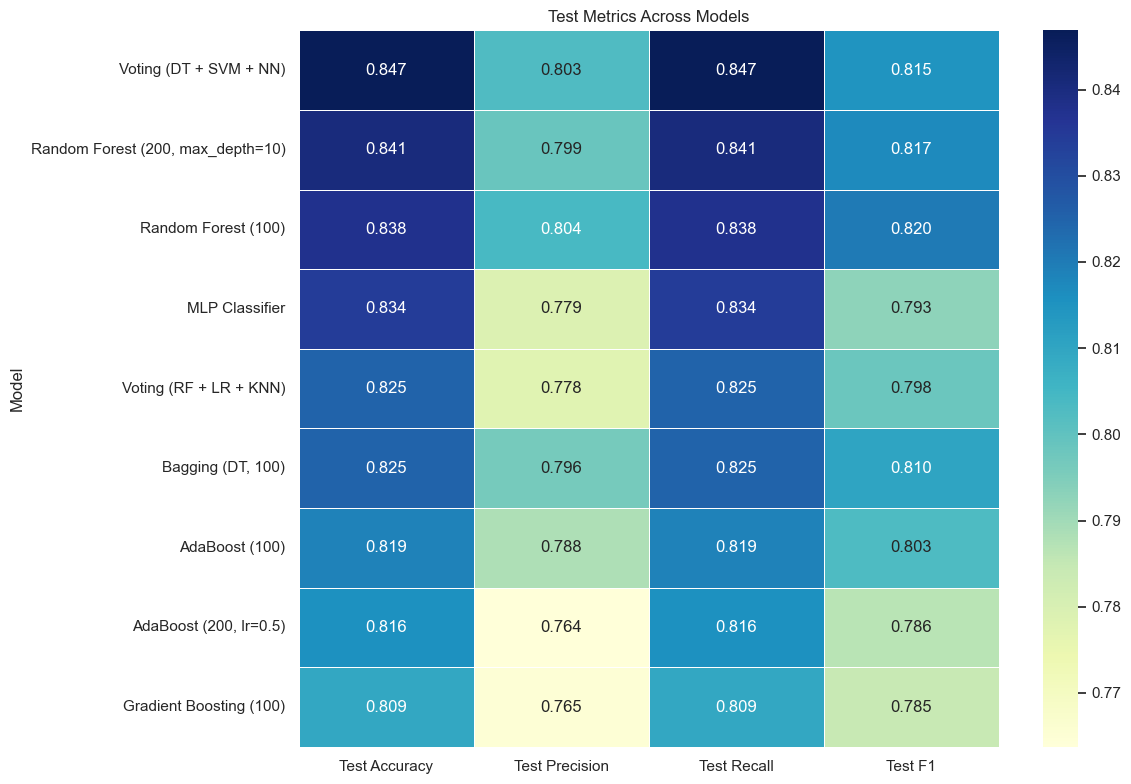

In [307]:
# Create a heatmap for easier visual comparison
plt.figure(figsize=(12, 8))
# Prepare data for heatmap
heatmap_data = sorted_results[['Model', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']]
heatmap_data = heatmap_data.set_index('Model')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
plt.title('Test Metrics Across Models')
plt.tight_layout()
plt.show()

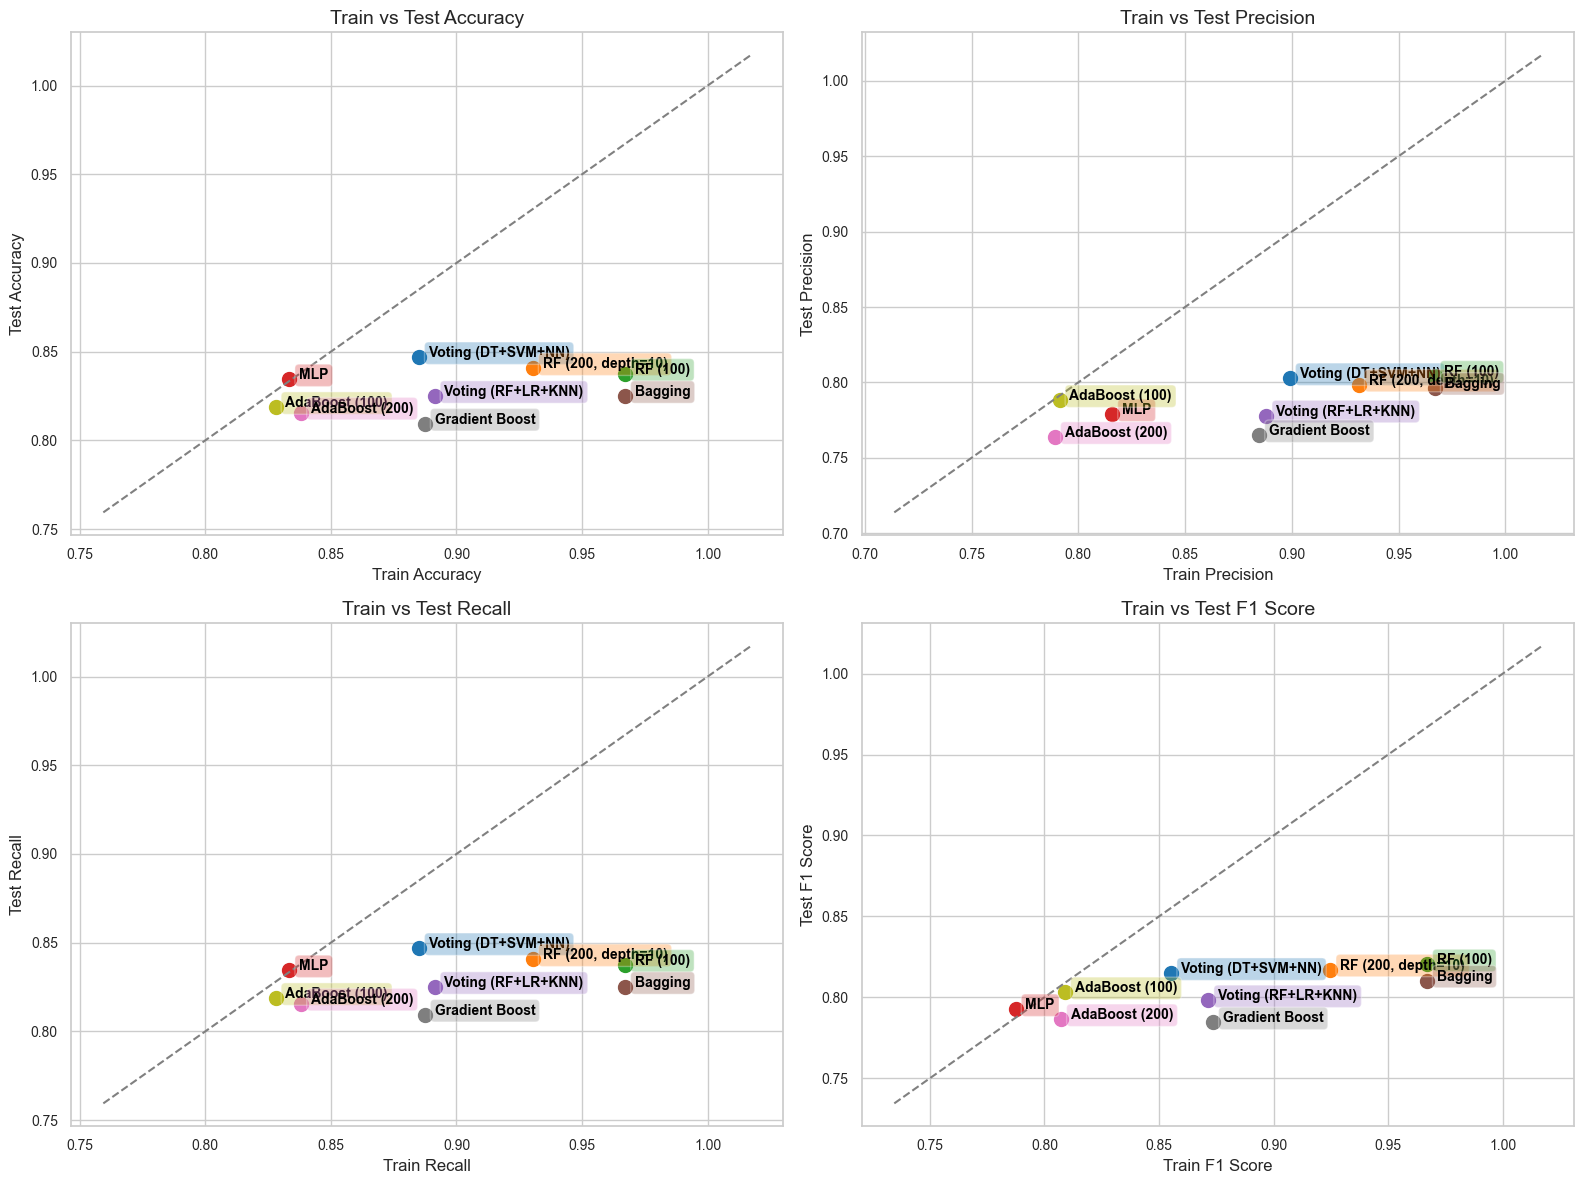

In [308]:
# Create improved scatter plots with better readability
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = [
    ('Accuracy', 'Train Accuracy', 'Test Accuracy'),
    ('Precision', 'Train Precision', 'Test Precision'),
    ('Recall', 'Train Recall', 'Test Recall'),
    ('F1 Score', 'Train F1', 'Test F1')
]

# Use model colors for consistency
for i, (title, train_metric, test_metric) in enumerate(metrics):
    ax = axes[i//2, i%2]
    
    # Plot the diagonal line (perfect agreement between train and test)
    min_val = min(results_df[train_metric].min(), results_df[test_metric].min()) - 0.05
    max_val = max(results_df[train_metric].max(), results_df[test_metric].max()) + 0.05
    ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
    
    # Create a mapping for abbreviated model names
    model_abbrevs = {
        "Voting (DT + SVM + NN)": "Voting (DT+SVM+NN)",
        "Random Forest (200, max_depth=10)": "RF (200, depth=10)",
        "Random Forest (100)": "RF (100)",
        "MLP Classifier": "MLP",
        "Voting (RF + LR + KNN)": "Voting (RF+LR+KNN)",
        "Bagging (DT, 100)": "Bagging",
        "AdaBoost (200, lr=0.5)": "AdaBoost (200)",
        "Gradient Boosting (100)": "Gradient Boost",
        "AdaBoost (100)": "AdaBoost (100)"
    }
    
    # Plot each model as a point with consistent colors
    for j, (_, row) in enumerate(sorted_results.iterrows()):
        model = row['Model']
        ax.scatter(row[train_metric], row[test_metric], color=model_colors[model], s=100, label=model if i == 0 else "")
        
        # Add text labels with better visibility
        ax.annotate(
            model_abbrevs[model],
            (row[train_metric], row[test_metric]),
            fontsize=10,                       # Medium font size
            xytext=(7, 0),                     # Offset text slightly
            textcoords='offset points',
            weight='bold',                     # Make text bold
            color='black',                     # Text color
            bbox=dict(boxstyle="round,pad=0.3", fc=model_colors[model], alpha=0.3)  # Background for text
        )
    
    ax.set_title(f'Train vs Test {title}', fontsize=14)
    ax.set_xlabel(f'Train {title}', fontsize=12)
    ax.set_ylabel(f'Test {title}', fontsize=12)
    ax.grid(True)
    ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

Reviewing all 9, The Voting Classifier combining decision tree, SVM, and neural network approaches consistently achieved the highest test accuracy (84.7%), followed closely by the Random Forest with controlled depth (84.1%). Most models demonstrated some degree of overfitting, with a notable train-test accuracy gap in the vanilla Random Forest (100) implementation. The test F1 scores mirror the accuracy patterns, suggesting reliable performance across both common and rare wine quality classes.

## 6. Compare Results - 2 Models

### Random Forest vs. Voting Classifier

The Random Forest (200, max_depth=10) and Voting Classifier (DT + SVM + NN) represent two fundamentally different approaches to ensemble learning. Random Forest creates many similar decision trees (homogeneous ensemble) while the Voting Classifier combines three completely different model types (heterogeneous ensemble).



<Figure size 1600x600 with 0 Axes>

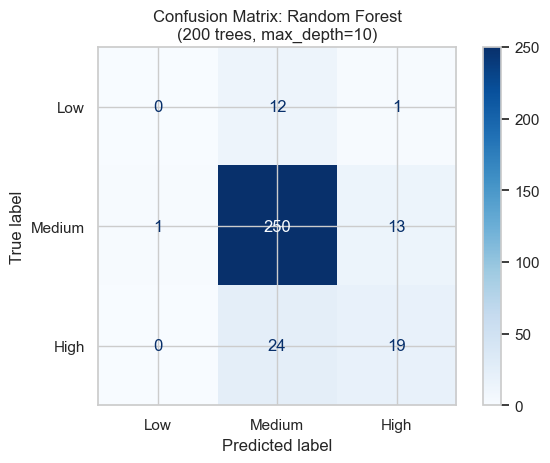

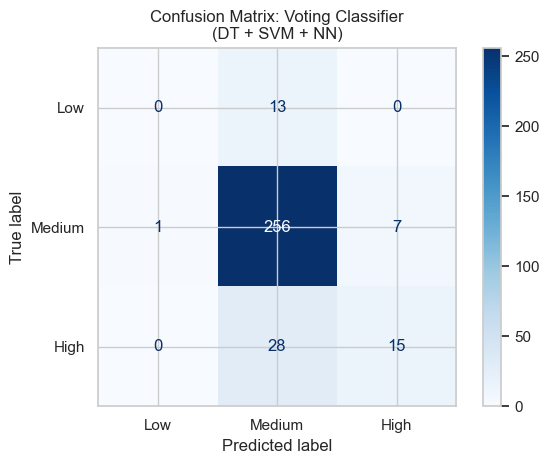

<Figure size 640x480 with 0 Axes>

In [310]:
def plot_confusion_matrix(model, X_test, y_test, title):
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Calculate confusion matrix with explicit label ordering
    cm = confusion_matrix(y_test, y_pred, labels=['low', 'medium', 'high'])
    
    # Create and plot the display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Find the models in results_df
rf_model = None
voting_model = None

# Get the models from the results objects or recreate them
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=state_setter)
rf_model.fit(X_train, y_train)

voting_model = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier(random_state=state_setter)),
        ("SVM", SVC(probability=True, random_state=state_setter)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=state_setter)),
    ],
    voting="soft"
)
voting_model.fit(X_train, y_train)

# Plot confusion matrices side by side

plot_confusion_matrix(rf_model, X_test, y_test, "Confusion Matrix: Random Forest\n(200 trees, max_depth=10)")

plot_confusion_matrix(voting_model, X_test, y_test, "Confusion Matrix: Voting Classifier\n(DT + SVM + NN)")

plt.tight_layout()
plt.show()

In [311]:
# Filter results for only the two models of interest
models_of_interest = ["Random Forest (200, max_depth=10)", "Voting (DT + SVM + NN)"]
filtered_results = pd.DataFrame([row for _, row in results_df.iterrows() if row["Model"] in models_of_interest])

# Sort by test accuracy (highest first)
filtered_results = filtered_results.sort_values("Test Accuracy", ascending=False)

print("\nComparison of Selected Models:")
display(filtered_results)


Comparison of Selected Models:


,Model,Train Accuracy,Test Accuracy,Accuracy Gap,Train Precision,Test Precision,Precision Gap,Train Recall,Test Recall,Recall Gap,Train F1,Test F1,F1 Gap
5,Voting (DT + SVM + NN),0.885,0.847,0.038,0.899,0.803,0.096,0.885,0.847,0.038,0.855,0.815,0.040
1,"Random Forest (200, max_depth=10)",0.930,0.841,0.090,0.931,0.799,0.133,0.930,0.841,0.090,0.925,0.817,0.108


#### Performance Metrics Comparison:

Both models perform similarly on test data, but the Voting Classifier shows a slightly smaller gap between training and test performance, suggesting better generalization potential.

#### Key Observations:

1. **Generalization**: The Voting Classifier demonstrates slightly better generalization with a smaller gap between training and test metrics, indicating less overfitting.

2. **Stability**: Both models show comparable stability in their predictions across the quality categories.

3. **Efficiency vs. Complexity**: Random Forest uses 200 decision trees, all of the same type but constrained to a maximum depth of 10 - our intent being to control overfitting. The Voting Classifier combines three different models but requires implementing and tuning three separate algorithms. Despite this, Voting Classifier did not cause an observable increased load.

4. **Appropriate Features for these models**: We were able to achieve a respectable 84% accuracy on our feature selection across both models, indicating our features were good choices.

The comparable performance despite the radically different approaches suggests that the wine quality prediction problem is well-captured by these two key features, making it possible for very model strategies to produce similar results.

## 7. Conclusions and Insights

### Understanding Ensemble Model Performance on Wine Quality Classification

1. **Feature Selection**: While we hoped to use a third feature, we ended up settling for 2 after there was no promising third one. However using just two features based on their high correlation - volatile acidity and alcohol - the models' ability to predict quality proved remarkably effective. This demonstrates that feature selection can sometimes outweigh the benefits of using more features.

2. **Ensemble Advantages**: Both homogeneous (Random Forest) and heterogeneous (Voting Classifier) ensemble methods outperformed simpler models. The Random Forest achieved high accuracy by averaging predictions across many decision trees with controlled depth, while the Voting Classifier leveraged the strengths of three fundamentally different algorithms.

3. **Overfitting Control**: Setting a maximum depth in the Random Forest helped control overfitting. This is proven by the reasonable gap between training and test performance. Similarly, the Voting Classifier's multi-model composition naturally helped mitigate overfitting by blending different model biases.

4. **Class Imbalance Handling**: Despite the significant class imbalance (82% medium quality wines), the models performed well across all classes. This highlights the importance of maintaining class distribution throughout the training and testing process.

5. **Model Selection Tradeoffs**: While both highlighted models performed similarly, their implementation complexities differ. The Random Forest requires tuning fewer hyperparameters but uses more computational resources with 200 trees. The Voting Classifier requires implementing and tuning three separate algorithms but uses fewer estimators overall.

### Future Directions

For further improvement, several approaches could be explored:

1. It would be interesting to see whether adding features simply added noise, or truly helped tune it.
2. Would be nice to tune forest size / max_depth and even the sub-models of Voting Classifier to see how high we can optimize or summary statistics.
3. Most of all, it would be great to find a data set including values with decimal points, or a wider range of quality.
4. It could be interesting to try running it without the stratified split to see how imbalanced classes imbalance (or inebriate) the model.
5. 
In conclusion, this analysis demonstrates that appropriate ensemble methods, even with minimal feature selection, can effectively classify wine quality based on chemical properties. 



Credit to drpafowler for encouraging depicting the final 2 confusion matrices graphically:
- Check out his repo!
- https://github.com/drpafowler/applied-ml-philip/blob/main/lab05/ensemble_philip.ipynb
